In [22]:
#!/usr/bin/env python

import os
import re
import json
import utility.utils as utils
from sklearn.neighbors import KNeighborsClassifier
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [23]:
#%% Parameters and variables

config_file = "config - monitored.json"

data_folder = "data"
# data_folder = "data_eduroam"

k = 5 # num of nearest neighbors for kNN

num_features = 5 # num of features to select out of 45
test_size = 0.2

normalize_data = 0

In [24]:
#%% Read the configuration and start training.
with open(config_file) as fp:

    print("* Parsing configuration")

    # Load the configuration from the file.
    config = json.load(fp)

    # This is where all the streams are going to live.
    streams = []

    # This is where all the labels are going to live.
    labels = []
    labels_str = []
    base_labels = [None] * len(config['pcaps'])

    # The base label starts from 1 and increments after that.
    current_label = 1
    pat = re.compile(".*-curl\.pcap$")

    for domain in config['pcaps']:
        # Set the base label.
        base_labels[current_label - 1] = domain

        # Increment the label
        current_label += 1

    utils.empty_csv()
    current_label = 1

    for domain in config['pcaps']:
        print(" - {}".format(domain))
        i = 0

        # Traverse the directory for all the pcaps.
        # for file in os.listdir('./pcaps/{}'.format(domain)):
        path = os.path.join("pcaps", data_folder, domain)
        for file in os.listdir(path):
            if file.endswith(".pcap") and (pat.match(file) is None):
                # if i > 20:
                #     break

                # This is the pcap file we'll be reading at this point.
                file = os.path.join(path, file)

                # Read the pcap file.
                data = utils.read_pcap_file(file)
                # data = utils1.extract_features3(file)

                # Append the data to the streams array.
                # streams.append(data)
                streams.append(data)

                # Append everything to the log.
                utils.append_to_csv(domain, data)

                # Add a label for the new file.
                labels.append(current_label)
                labels_str.append(domain)

                i += 1

        print(f"    {i} pcap files")

        # Increment the label
        current_label += 1


* Parsing configuration
 - amazon.com
OUT: 44,IN: 50,TOTAL: 94,SIZE: 160856,RATIO: 1.1363636363636365
OUT: 55,IN: 63,TOTAL: 118,SIZE: 158596,RATIO: 1.1454545454545455
OUT: 44,IN: 51,TOTAL: 95,SIZE: 154255,RATIO: 1.1590909090909092
OUT: 79,IN: 77,TOTAL: 156,SIZE: 16507,RATIO: 0.9746835443037974
OUT: 50,IN: 55,TOTAL: 105,SIZE: 155962,RATIO: 1.1
OUT: 55,IN: 61,TOTAL: 116,SIZE: 191965,RATIO: 1.1090909090909091
OUT: 47,IN: 52,TOTAL: 99,SIZE: 158508,RATIO: 1.1063829787234043
OUT: 44,IN: 52,TOTAL: 96,SIZE: 152080,RATIO: 1.1818181818181819
OUT: 60,IN: 64,TOTAL: 124,SIZE: 158071,RATIO: 1.0666666666666667
OUT: 41,IN: 48,TOTAL: 89,SIZE: 192289,RATIO: 1.170731707317073
OUT: 47,IN: 60,TOTAL: 107,SIZE: 201387,RATIO: 1.2765957446808511
OUT: 7,IN: 7,TOTAL: 14,SIZE: 2010,RATIO: 1.0
OUT: 53,IN: 63,TOTAL: 116,SIZE: 161656,RATIO: 1.1886792452830188
OUT: 51,IN: 72,TOTAL: 123,SIZE: 23899,RATIO: 1.411764705882353
OUT: 80,IN: 86,TOTAL: 166,SIZE: 250852,RATIO: 1.075
OUT: 48,IN: 55,TOTAL: 103,SIZE: 97098,RATIO:

In [25]:

streams = np.array(streams)
labels = np.array(labels)
# print(streams)
# print(labels)

unmonitored_label = len(base_labels)

#%%

if normalize_data:
    streamsnorm = norm.fit_transform(streams[:, :num_features])
else:
    streamsnorm = streams[:, :num_features]
    
print("First sample of the data:")
print(streamsnorm[0])

X_train, X_test, y_train, y_test = \
    train_test_split(streamsnorm, labels, test_size=test_size, random_state=42, 
                     stratify=labels)

count = Counter(y_test)
print(sorted(count.items()))


# Initialize the RF classifier.
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

# get the leaf indices for the training data
train_leafs = rf.apply(X_train)

# create a KNN classifier using the leaf indices as the new training data
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=k)
knn.fit(train_leafs, y_train)

First sample of the data:
[1.60856000e+05 9.40000000e+01 4.40000000e+01 5.00000000e+01
 1.13636364e+00]
[(1, 9), (2, 9), (3, 9), (4, 9), (5, 8), (6, 8), (7, 9), (8, 9), (9, 9), (10, 9), (11, 14)]


KNeighborsClassifier(n_jobs=-1)

In [26]:

def kFP(rf, knn, X_test):
    
    # assuming X_test is your test data
    test_leaf = rf.apply(X_test)
    knn_pred = knn.predict(test_leaf)
    
    # get the k nearest neighbors' labels for each test observation
    knn_neighbors = knn.kneighbors(test_leaf, return_distance=False)
    knn_labels = y_train[knn_neighbors]
    
    # classify as 'unmonitored' if not all k nearest labels agree
    y_pred = np.where((knn_labels == knn_pred.reshape(-1, 1)).all(axis=1), 
                      knn_pred, unmonitored_label)

    y_pred = knn_pred # Direct kNN output, no kFP
    return y_pred



Accuracy on test set: 57.84313725490197%
[[5 0 0 1 0 0 0 0 0 3 0]
 [0 6 0 0 0 0 0 0 1 0 2]
 [0 0 4 0 1 0 0 1 3 0 0]
 [0 1 0 7 0 0 0 0 0 0 1]
 [0 0 1 2 3 0 0 0 0 0 2]
 [0 0 0 0 0 7 0 0 0 0 1]
 [0 1 0 3 1 0 4 0 0 0 0]
 [0 0 0 2 0 0 1 6 0 0 0]
 [0 0 4 0 0 0 0 0 5 0 0]
 [0 1 0 0 1 1 0 0 0 5 1]
 [1 0 0 0 3 0 0 0 2 1 7]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


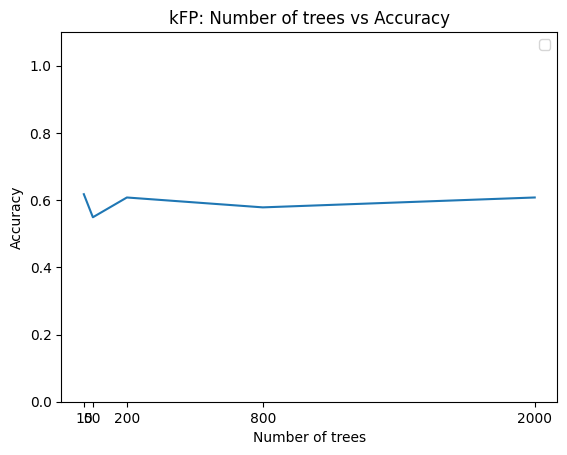

In [27]:
# Save a snapshot of this classifier.
# dump(clf, "./classifier-nb.dmp", compress=9)

# Get the prediction.
y_pred = kFP(rf, knn, X_train)

# print("Accuracy on train set: %s%%" % (accuracy_score(y_train, y_pred) * 100,))

# Get the prediction.
y_pred = kFP(rf, knn, X_test)

print("Accuracy on test set: %s%%" % (accuracy_score(y_test, y_pred) * 100,))

print(confusion_matrix(y_test, y_pred))

#%% Num of trees vs accuracy

ntrees = np.array([10, 50, 200, 800, 2000])
train_accuracies = []
test_accuracies = []
k = 4

for nt in ntrees:
    
    # Initialize the RF classifier.
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=nt)
    rf.fit(X_train, y_train)

    # get the leaf indices for the training data
    train_leafs = rf.apply(X_train)

    # create a KNN classifier using the leaf indices as the new training data
    knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=k)
    knn.fit(train_leafs, y_train)
    
    y_pred_train = kFP(rf, knn, X_train)
    y_pred_test = kFP(rf, knn, X_test)
    
    # calculate accuracy on training and test sets
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)  
    # append accuracies to lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.plot(ntrees, test_accuracies)
plt.xticks(ntrees)
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('kFP: Number of trees vs Accuracy')
plt.legend()
plt.ylim([0, 1.1])
plt.show()
#%% Num of nearets neighbors (k) vs accuracy for kFP

# lists to store accuracies for different numbers of nearest neighbors
neighbors = list(range(1, 20))
train_accuracies = []
test_accuracies = []

# Initialize the RF classifier.
rf = RandomForestClassifier(n_jobs=-1, n_estimators=1000)
rf.fit(X_train, y_train)

# get the leaf indices for the training data
train_leafs = rf.apply(X_train)

In [28]:

def kFP1(rf, k, X_test): # Classify as 'unmonitored' if not all k nearest labels agree
    
    # create a KNN classifier using the leaf indices as the new training data
    knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=k)
    knn.fit(train_leafs, y_train)
    
    test_leaf = rf.apply(X_test)
    knn_pred = knn.predict(test_leaf)
    
    # get the k nearest neighbors' labels for each test observation
    knn_neighbors = knn.kneighbors(test_leaf, return_distance=False)
    knn_labels = y_train[knn_neighbors]
    
    # classify as 'unmonitored' if not all k nearest labels agree
    y_pred = np.where((knn_labels == knn_pred.reshape(-1, 1)).all(axis=1), 
                      knn_pred, unmonitored_label)

    # y_pred = knn_pred # Direct kNN output, no kFP
    return y_pred

def kFP2(rf, k, X_test): # Direct output from kNN after extracting leaf output from RF
    
    # create a KNN classifier using the leaf indices as the new training data
    knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=k)
    knn.fit(train_leafs, y_train)
    
    test_leaf = rf.apply(X_test)
    knn_pred = knn.predict(test_leaf)
    
    # # get the k nearest neighbors' labels for each test observation
    # knn_neighbors = knn.kneighbors(test_leaf, return_distance=False)
    # knn_labels = y_train[knn_neighbors]
    
    # # classify as 'unmonitored' if not all k nearest labels agree
    # y_pred = np.where((knn_labels == knn_pred.reshape(-1, 1)).all(axis=1), 
    #                   knn_pred, unmonitored_label)

    y_pred = knn_pred # Direct kNN output, no kFP
    return y_pred


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


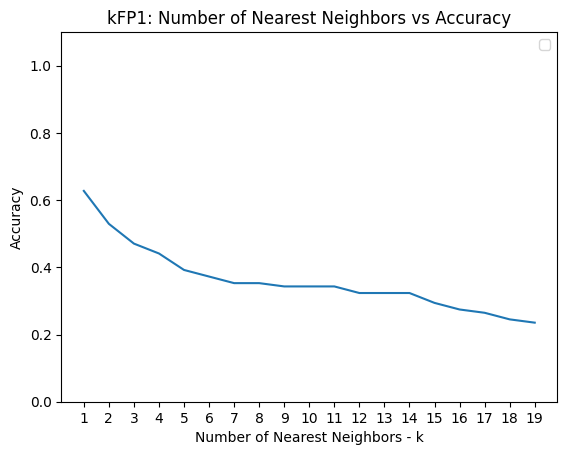

In [29]:

for k in neighbors:
    
    y_pred_train = kFP1(rf, k, X_train)
    y_pred_test = kFP1(rf, k, X_test)
    
    # calculate accuracy on training and test sets
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)  
    # append accuracies to lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# plot number of nearest neighbors vs accuracy 
plt.plot(neighbors, test_accuracies)
plt.xticks(neighbors)
plt.xlabel('Number of Nearest Neighbors - k')
plt.ylabel('Accuracy')
plt.title('kFP1: Number of Nearest Neighbors vs Accuracy')
plt.legend()
plt.ylim([0, 1.1])
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


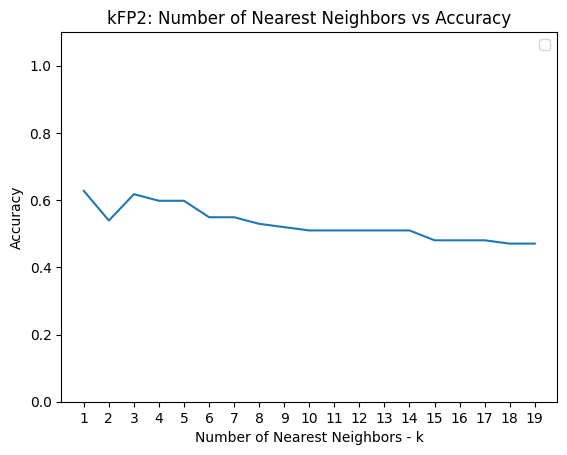

In [30]:

train_accuracies = []
test_accuracies = []

for k in neighbors:
    
    y_pred_train = kFP2(rf, k, X_train)
    y_pred_test = kFP2(rf, k, X_test)
    
    # calculate accuracy on training and test sets
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)  
    # append accuracies to lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# plot number of nearest neighbors vs accuracy
plt.plot(neighbors, test_accuracies)
plt.xticks(neighbors)
plt.xlabel('Number of Nearest Neighbors - k')
plt.ylabel('Accuracy')
plt.title('kFP2: Number of Nearest Neighbors vs Accuracy')
plt.legend()
plt.ylim([0, 1.1])
plt.show()
